In [1]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/keshavsanthanam/workspace/gpusched/scheduler')
import utils

In [3]:
throughputs = utils.read_all_throughputs_json_v2('/Users/keshavsanthanam/Downloads/consolidated_throughputs_v1.json')

In [4]:
worker_types = sorted(throughputs.keys())

In [5]:
# Check that all worker types have the same keys.
k80_keys = set(throughputs['k80'].keys())
p100_keys = set(throughputs['p100'].keys())
v100_keys = set(throughputs['v100'].keys())
assert k80_keys == v100_keys
for key in k80_keys - p100_keys:
    assert key[1] == 8
all_job_types = k80_keys

In [6]:
def parse_key(key):
    match = re.match('(.*) \(batch size (\d+)\)', key[0])
    if match is not None:
        model = match.group(1)
        batch_size = int(match.group(2))
    else:
        model = key[0]
        batch_size = 1
    return (model, batch_size, key[1])

In [7]:
isolated_throughputs = {}
for worker_type in worker_types:
    isolated_throughputs[worker_type] = {}
    for job_type in all_job_types:
        if job_type not in throughputs[worker_type]:
            continue
        model, batch_size, scale_factor = parse_key(job_type)
        if model not in isolated_throughputs[worker_type]:
            isolated_throughputs[worker_type][model] = {}
        if batch_size not in isolated_throughputs[worker_type][model]:
            isolated_throughputs[worker_type][model][batch_size] = {}
        isolated_throughputs[worker_type][model][batch_size][scale_factor] =\
            throughputs[worker_type][job_type]['null']

In [8]:
def plot_throughputs_for_model(isolated_throughputs, model):
    batch_sizes = sorted(isolated_throughputs['k80'][model].keys())
    min_throughput = isolated_throughputs['k80'][model][batch_sizes[0]][1] * batch_sizes[0]
    data = {}
    ymax = 0
    for i, worker_type in enumerate(worker_types):
        data[worker_type] = {}
        for batch_size in batch_sizes:
            scale_factors = sorted(isolated_throughputs[worker_type][model][batch_size].keys())
            data[worker_type][batch_size] = []
            for scale_factor in scale_factors:
                data[worker_type][batch_size].append(
                    isolated_throughputs[worker_type][model][batch_size][scale_factor] * batch_size / min_throughput)
            ymax = max(ymax, max(data[worker_type][batch_size]))
    for i, worker_type in enumerate(worker_types):
        for batch_size in batch_sizes:
            scale_factors = sorted(isolated_throughputs[worker_type][model][batch_size].keys())
            plt.plot(scale_factors,
                     data[worker_type][batch_size],
                     label='batch size %d' % (batch_size),
                     marker='o')
        plt.ylim(0, ymax * 1.1)
        plt.xticks([int(2 ** i) for i in range(4)])
        plt.xlabel('Scale factor')
        plt.ylabel('Normalized throughput\n(vs k80 batch size %d)' % (batch_sizes[0]))
        plt.legend()
        plt.title('%s %s' % (model, worker_type))
        if i < len(worker_types) - 1:
            plt.figure()

In [9]:
def plot_throughputs_for_single_gpu_model(isolated_throughputs, model):
    batch_sizes = sorted(isolated_throughputs['k80'][model].keys())
    min_throughput = isolated_throughputs['k80'][model][batch_sizes[0]][1] * batch_sizes[0]
    data = {}
    for worker_type in worker_types:
        data[worker_type] = []
        for batch_size in batch_sizes:
            data[worker_type].append(isolated_throughputs[worker_type][model][batch_size][1] * batch_size / min_throughput)
        plt.plot(batch_sizes, data[worker_type], label=worker_type, marker='o')
    plt.xlabel('Batch size')
    plt.ylabel('Normalized throughput\n(vs k80 batch size %d)' % (batch_sizes[0]))
    plt.xticks(batch_sizes)
    plt.title(model)
    plt.ylim(ymin=0.0)
    plt.legend()
    plt.show()

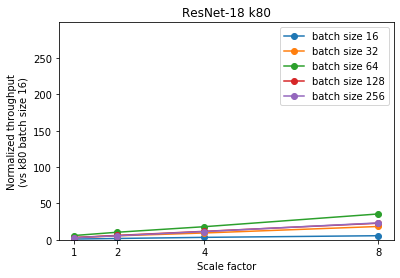

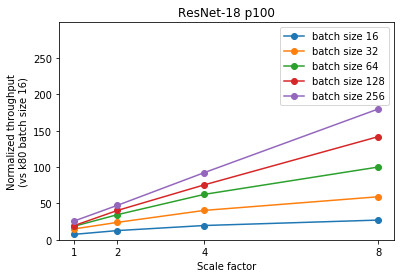

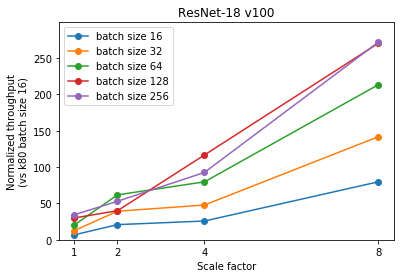

In [10]:
plot_throughputs_for_model(isolated_throughputs, 'ResNet-18')

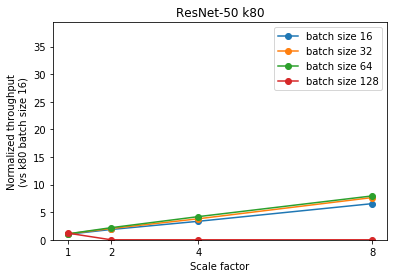

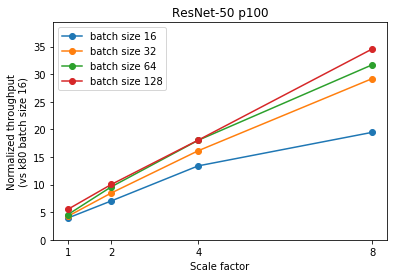

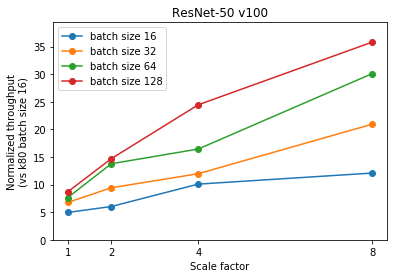

In [11]:
plot_throughputs_for_model(isolated_throughputs, 'ResNet-50')

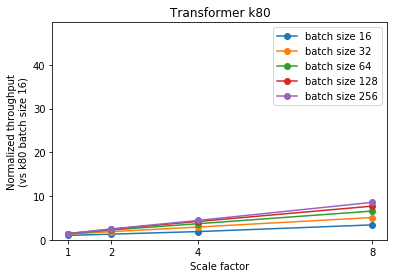

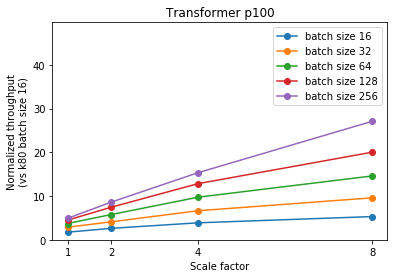

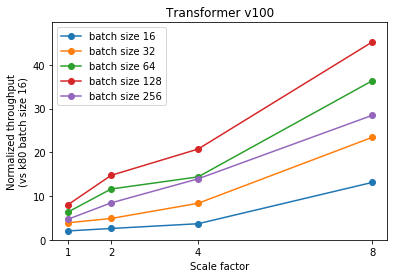

In [12]:
plot_throughputs_for_model(isolated_throughputs, 'Transformer')

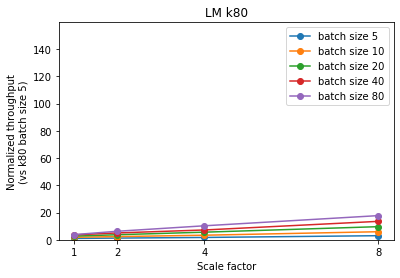

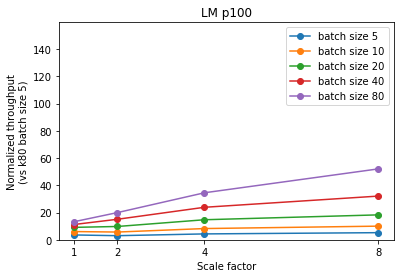

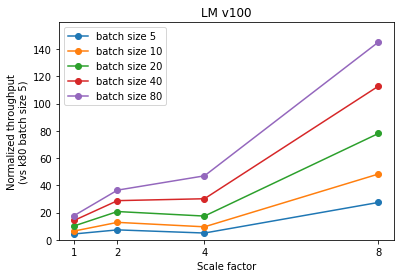

In [13]:
plot_throughputs_for_model(isolated_throughputs, 'LM')